<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

random.seed(42)
np.random.seed(42)
pd.options.display.float_format = '{:.2f}'.format

### **Задание 0**
Для чего фиксируем сиды в домашках?

`Чтобы обеспечить повторяемость результатов зависящих от случайных чисел.`

# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [7]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


In [25]:
df_test[list(set(df_test.columns) - set(('selling_price',)))].to_csv(r"C:\Users\Ilya\Desktop\tt.csv", encoding="utf-8-sig")

In [21]:
set(('selling_price',))

{'selling_price'}

### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла)

In [174]:
display(df_train.isna().any(), df_test.isna().any())

name             False
year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
torque            True
seats             True
dtype: bool

name             False
year             False
selling_price    False
km_driven        False
fuel             False
seller_type      False
transmission     False
owner            False
mileage           True
engine            True
max_power         True
torque            True
seats             True
dtype: bool

In [175]:
# список колонок, которые имеют пропуски
for i, row in zip(df_train.isna().any().to_list(), df_train.isna().any().index):
    if i == True:
        print(row)

mileage
engine
max_power
torque
seats


In [176]:
print("Есть явные дубликаты?", df_train.duplicated().any())

Есть явные дубликаты? True


In [177]:
pip install ydata-profiling -q

Note: you may need to restart the kernel to use updated packages.


In [178]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df_train, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

`К базовым выводам можно отнести высокую значимую отрицательную корреляцию -0.620 между km_driven и year, а так же положительную корреляцию 0.714 year selling_price.
Поле Dataset иеет 493 (7.0%) пропусков. Поле seller_type не сбалансированно, т к individual занимает 80%. 
Поля engine и max_power имеют пропуски 202 и 196 соответсвенно.`
`Так же целевая переменная имеет значимую корреляцию с transmition и мало значимые корреляцие с km_drived, owner`

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [181]:
from IPython.display import display, HTML
# https://stackoverflow.com/a/57832026
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

display_side_by_side([df_train.describe(include="number"), df_test.describe(include="number")], ['df_train', 'df_test'])

In [182]:
display(df_train.describe(include="O"), df_test.describe(include="O"))

name    fuel seller_type transmission        owner  \
count                     6999    6999        6999         6999         6999   
unique                    1924       4           3            2            5   
top     Maruti Swift Dzire VDI  Diesel  Individual       Manual  First Owner   
freq                       116    3793        5826         6095         4587   

          mileage   engine max_power          torque  
count        6797     6797      6803            6796  
unique        386      120       316             419  
top     18.9 kmpl  1248 CC    74 bhp  190Nm@ 2000rpm  
freq          197      885       330             468

name    fuel seller_type transmission        owner  \
count                  1000    1000        1000         1000         1000   
unique                  621       4           3            2            5   
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner   
freq                     15     534         837          877          623   

          mileage   engine max_power          torque  
count         981      981       981             981  
unique        237       88       182             226  
top     18.6 kmpl  1248 CC    74 bhp  200Nm@ 1750rpm  
freq           23      116        43              57

` Между train и test: Средние значения и медианы в test и train почти не отличаются везде, кроме поля  selling_price. Схожесть показателей говорит о том, что данные train и test однородны, и модель должна хорошо справляться с новыми данными.`

`Внутри train и test:
Значения selling_price сильно отличаются это может значить, что есть выбросы или асимметрия в распределении данных. ` 

### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.05 балла)
- [ ] Отобразите такие объекты (0.05 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.05 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.05 балла)

In [186]:
features = df_train.columns.drop('selling_price')
duplicates = df_train.duplicated(subset=features)
num_duplicates = duplicates.sum()
print(f'Количество дубликатов: {num_duplicates}')

Количество дубликатов: 1159


In [187]:
df_train[duplicates]

name  year  selling_price  \
254                   Hyundai Grand i10 Sportz  2017         450000   
258                           Maruti Swift VXI  2012         330000   
268                     Maruti Swift Dzire VXI  2014         400000   
324   Jaguar XE 2016-2019 2.0L Diesel Prestige  2017        2625000   
325                              Lexus ES 300h  2019        5150000   
...                                        ...   ...            ...   
6947                    Chevrolet Spark 1.0 LS  2010         140000   
6984  Ford Freestyle Titanium Plus Diesel BSIV  2018         746000   
6989                    Maruti Swift Dzire VDI  2015         625000   
6997                           Tata Indigo CR4  2013         290000   
6998                           Tata Indigo CR4  2013         290000   

      km_driven    fuel seller_type transmission         owner     mileage  \
254       35000  Petrol  Individual       Manual   First Owner   18.9 kmpl   
258       50000  Petrol  Individual       Manual  Second Owner   18.6 kmpl   
268       70000  Petrol  Individual       Manual  Second Owner   19.1 kmpl   
324        9000  Diesel      Dealer    Automatic   First Owner   13.6 kmpl   
325       20000  Petrol      Dealer    Automatic   First Owner  22.37 kmpl   
...         ...     ...         ...          ...           ...         ...   
6947      60000  Petrol  Individual       Manual  Second Owner   18.0 kmpl   
6984      24000  Diesel  Individual       Manual   First Owner   24.4 kmpl   
6989      50000  Diesel  Individual       Manual   First Owner  26.59 kmpl   
6997      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   
6998      25000  Diesel  Individual       Manual   First Owner  23.57 kmpl   

       engine   max_power               torque  seats  
254   1197 CC      82 bhp       114Nm@ 4000rpm   5.00  
258   1197 CC    85.8 bhp       114Nm@ 4000rpm   5.00  
268   1197 CC    85.8 bhp       114Nm@ 4000rpm   5.00  
324   1999 CC     177 bhp  430Nm@ 1750-2500rpm   5.00  
325   2487 CC  214.56 bhp  202Nm@ 3600-5200rpm   5.00  
...       ...         ...                  ...    ...  
6947   995 CC      62 bhp      90.3Nm@ 4200rpm   5.00  
6984  1498 CC   98.63 bhp  215Nm@ 1750-3000rpm   5.00  
6989  1248 CC      74 bhp       190Nm@ 2000rpm   5.00  
6997  1396 CC      70 bhp  140Nm@ 1800-3000rpm   5.00  
6998  1396 CC      70 bhp  140Nm@ 1800-3000rpm   5.00  

[1159 rows x 13 columns]

In [191]:
df_train[(df_train['name'] == 'Hyundai Grand i10 Sportz') & (df_train['year'] == 2017)]

name  year  selling_price  km_driven    fuel  \
253   Hyundai Grand i10 Sportz  2017         450000      35000  Petrol   
254   Hyundai Grand i10 Sportz  2017         450000      35000  Petrol   
678   Hyundai Grand i10 Sportz  2017         500000      20000  Petrol   
1492  Hyundai Grand i10 Sportz  2017         509999      25000  Petrol   
2149  Hyundai Grand i10 Sportz  2017         459999      70000  Petrol   
3497  Hyundai Grand i10 Sportz  2017         550000      23456  Petrol   
4225  Hyundai Grand i10 Sportz  2017         550000      23456  Petrol   

     seller_type transmission        owner    mileage   engine max_power  \
253   Individual       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
254   Individual       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
678   Individual       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
1492  Individual       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
2149  Individual       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
3497      Dealer       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   
4225      Dealer       Manual  First Owner  18.9 kmpl  1197 CC    82 bhp   

              torque  seats  
253   114Nm@ 4000rpm   5.00  
254   114Nm@ 4000rpm   5.00  
678   114Nm@ 4000rpm   5.00  
1492  114Nm@ 4000rpm   5.00  
2149  114Nm@ 4000rpm   5.00  
3497  114Nm@ 4000rpm   5.00  
4225  114Nm@ 4000rpm   5.00

In [192]:
df_train = df_train.drop_duplicates(subset=features, keep="first")
display(df_train.index)
df_train.reset_index(drop=True, inplace=True)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       6986, 6987, 6988, 6990, 6991, 6992, 6993, 6994, 6995, 6996],
      dtype='int64', length=5840)

In [193]:
df_train.index

RangeIndex(start=0, stop=5840, step=1)

In [194]:
assert df_train.shape == (5840, 13)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [196]:
import re

def preprocess_torque(dataframe):
    def extract_torque_value(torque_str):
        if pd.isna(torque_str):
            return np.nan, np.nan
        match = re.match(r'^([\d\.\,]+)\s*(?:\w\w|\w\w\w|@|\s)[@\s|\sat\s|/]*([\d\-\,\~\@\s\+\-\/]*)(?:rpm|RPM|\(kgm@ rpm\)|\(NM@ rpm\)|\s)?$', torque_str.strip())
        if not match:
            print(f"Не могу разобрать строку: '{torque_str}'")
            return np.nan, np.nan
            
        value = float(match.group(1).replace(',', '.'))
        rpm_range = match.group(2).strip().replace('@', '').replace(' ', '').replace("'", '')
        rpm_range = rpm_range.replace(',', '')
        
        if '+/-' in rpm_range:
            rpm_start, rpm_end = map(int, rpm_range.split('+/-'))
            rpm_end += rpm_start
        elif '-' in rpm_range or '~' in rpm_range:
            rpm_start, rpm_end = rpm_range.split('-') if '-' in rpm_range else rpm_range.split('~')
            rpm_start = int(rpm_start)
            rpm_end = int(rpm_end)
        elif ',' in rpm_range:
            rpm_start, rpm_end = rpm_range.split(',')
            rpm_start = int(rpm_start)
            rpm_end = int(rpm_end)
        elif rpm_range == '':
            rpm_start = None
            rpm_end = None
        else:
            rpm_start = int(rpm_range)
            rpm_end = rpm_start

        if rpm_end:
            rpm = int(rpm_end)
        elif rpm_start:
            rpm = int(rpm_start)
        else:
            rpm = np.nan
        if  rpm > 10000:
            print(rpm_range)
        return value, rpm

    # data = dataframe['torque'].apply(extract_torque_value).apply(pd.Series)
    # dataframe.loc[:, 'torque_value'] = data[0]
    # dataframe.loc[:, 'max_torque_rpm'] = data[1]
    dataframe = dataframe['torque'].apply(extract_torque_value).apply(pd.Series)[[0, 1]]
    dataframe.rename(columns={0: 'torque_value', 1: 'max_torque_rpm'}, inplace=True)
    dataframe['max_torque_rpm'] = dataframe['max_torque_rpm'].astype("Int64")
    # dataframe = dataframe.drop(columns=['torque'])

    return dataframe
# train_data = pd.DataFrame({'torque': ['11.5@ 4,500(kgm@ rpm)', '190Nm@ 2000rpm', '250Nm@ 1500-2500rpm', '22.4 kgm at 1750-2750rpm', ]})
# df_new = preprocess_torque(df_train[['torque']]) 
# pd.concat([df_train, df_new], axis=1)
# preprocess_torque(train_data)

`значение 21800 лучше заменить на схожее по другим параметрам, т к скорее всего это просто ошибка заполнения`

In [198]:
df_new = preprocess_torque(df_train[['torque']])
df_train = pd.concat([df_train, df_new], axis=1)
df_train = df_train.drop(columns=['torque'])

df_new = preprocess_torque(df_test[['torque']])
df_test = pd.concat([df_test, df_new], axis=1)
df_test = df_test.drop(columns=['torque'])

Не могу разобрать строку: '380Nm(38.7kgm)@ 2500rpm'
21800
Не могу разобрать строку: '110(11.2)@ 4800'


In [199]:
df_train[df_train['max_torque_rpm'] == 21800]

name  year  selling_price  km_driven    fuel seller_type  \
3936  Tata Sumo EX TC  2005         225000     188000  Diesel  Individual   

     transmission        owner    mileage   engine max_power  seats  \
3936       Manual  First Owner  12.3 kmpl  1948 CC    90 bhp   7.00   

      torque_value  max_torque_rpm  
3936        190.00           21800

In [200]:
df_train[df_train['name'].str.contains('Tata Sumo EX')]

name  year  selling_price  km_driven    fuel  \
1616  Tata Sumo EX 10/7 Str BSIII  2012         200000      67500  Diesel   
3810  Tata Sumo EX 10/7 Str BSIII  2008         200000      80000  Diesel   
3936              Tata Sumo EX TC  2005         225000     188000  Diesel   
4342                 Tata Sumo EX  2016         445000      63000  Diesel   

     seller_type transmission        owner    mileage   engine max_power  \
1616  Individual       Manual  First Owner  12.2 kmpl  1948 CC    68 bhp   
3810  Individual       Manual  First Owner  12.2 kmpl  1948 CC    68 bhp   
3936  Individual       Manual  First Owner  12.3 kmpl  1948 CC    90 bhp   
4342      Dealer       Manual  First Owner  15.3 kmpl  2956 CC  83.8 bhp   

      seats  torque_value  max_torque_rpm  
1616  10.00        115.00            2500  
3810  10.00        115.00            2500  
3936   7.00        190.00           21800  
4342   9.00        250.00            2000

`Странно, что машина из 2016 имеет меньше rpm чем из 2005, да и в 10 раз, так что поделим на 10`

In [202]:
df_train.loc[df_train['max_torque_rpm'] == 21800, 'max_torque_rpm'] = df_train.loc[df_train['max_torque_rpm'] == 21800, 'max_torque_rpm']/10
df_train.loc[df_train['max_torque_rpm'] == 2180, 'max_torque_rpm']

3936    2180
Name: max_torque_rpm, dtype: Int64

In [203]:
def clean_and_convert_to_float(df, columns):
    for col in columns:
        df[col] = df[col].str.replace(r'[^\d\.]', '', regex=True).replace(r'', '0.0', regex=True).astype(float)
    return df

columns_to_clean = ['mileage', 'engine', 'max_power']
df_train = clean_and_convert_to_float(df_train, columns_to_clean)
df_test = clean_and_convert_to_float(df_test, columns_to_clean)

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [205]:
for column in df_train.select_dtypes(include='number').columns:
    median_train = df_train[column].median()
    df_train.loc[:, column] = df_train[column].fillna(median_train)
    
    median_test = df_test[column].median()
    df_test.loc[:, column] = df_test[column].fillna(median_test)

In [206]:
np.set_printoptions(precision=3, suppress=True)

In [207]:
with np.printoptions(precision=3, suppress=True):
    display(df_train['max_torque_rpm'].unique())

<IntegerArray>
[2000, 2500, 2750, 4500, 4000, 2400, 2250, 3000, 3500, 3600, 1750, 4850, 2700,
 4600, 4800, 3400, 2800, 3250, 3750, 3800, 4200, 4250, 1900, 5200, 5000, 1800,
 1600, 4700, 1400, 1740, 4300, 3200, 4386, 1500, 2200, 4400, 2600, 5300, 4388,
 4100, 4750, 3300, 3100, 1850, 2650, 2180]
Length: 46, dtype: Int64

In [208]:
df_test.select_dtypes(include='number')

year  selling_price  km_driven  mileage  engine  max_power  seats  \
0    2010         229999     168000    14.00 2498.00     112.00   7.00   
1    2017         665000      25000    21.50 1497.00     108.50   5.00   
2    2007         175000     218463    12.90 1799.00     130.00   5.00   
3    2015         635000     173000    25.10 1498.00      98.60   5.00   
4    2011         130000      70000    16.50 1172.00      65.00   5.00   
..    ...            ...        ...      ...     ...        ...    ...   
995  2008         250000     100000    19.81 1086.00      68.05   5.00   
996  2017         440000      50000    18.60 1197.00      81.83   5.00   
997  2009         340000      40000    23.00 1396.00      90.00   5.00   
998  2012         350000      25000    20.36 1197.00      78.90   5.00   
999  2016         700000     110000    26.00 1498.00      98.60   5.00   

     torque_value  max_torque_rpm  
0          260.00            2200  
1          260.00            2750  
2          172.00            4300  
3          200.00            1750  
4           96.00            3000  
..            ...             ...  
995         99.04            4500  
996        114.70            4000  
997         22.40            2750  
998        111.80            4000  
999        200.00            1750  

[1000 rows x 9 columns]

In [210]:
display(df_train.isna().any(), df_test.isna().any())

name              False
year              False
selling_price     False
km_driven         False
fuel              False
seller_type       False
transmission      False
owner             False
mileage           False
engine            False
max_power         False
seats             False
torque_value      False
max_torque_rpm    False
dtype: bool

name              False
year              False
selling_price     False
km_driven         False
fuel              False
seller_type       False
transmission      False
owner             False
mileage           False
engine            False
max_power         False
seats             False
torque_value      False
max_torque_rpm    False
dtype: bool

In [211]:
df_train.describe(include='number')

year  selling_price  km_driven  mileage  engine  max_power   seats  \
count 5840.00        5840.00    5840.00  5840.00 5840.00    5840.00 5840.00   
mean  2013.43      522960.09   73952.24    19.43 1429.45      87.89    5.43   
std      4.10      535432.00   60071.14     3.99  485.66      31.66    0.98   
min   1983.00       29999.00       1.00     0.00  624.00       0.00    2.00   
25%   2011.00      250000.00   39000.00    16.95 1197.00      68.00    5.00   
50%   2014.00      405000.00   70000.00    19.37 1248.00      81.86    5.00   
75%   2017.00      640000.00  100000.00    22.30 1498.00      99.00    5.00   
max   2020.00    10000000.00 2360457.00    42.00 3604.00     400.00   14.00   

       torque_value  max_torque_rpm  
count       5840.00         5840.00  
mean         161.27         3043.37  
std           91.13          878.48  
min            4.80         1400.00  
25%           99.04         2250.00  
50%          150.00         3000.00  
75%          200.00         4000.00  
max          789.00         5300.00

`Почему стоит применять медиану?`

    `1) Медиана менее чувствительна к экстремальным значениям, чем среднее арифметическое.
    2) Медиана является мерой центральной тенденции, которая показывает середину упорядоченных данных. Она дает лучшее представление о типичном значении в случае несимметричных распределений.`

`Могли ли мы применить среднее?`

`Да, применение среднего тоже возможно, особенно если данные симметричны и не содержат выбросов. В данном случае это допустимо для km_driven, mileage, seats (округление до целого), т к тут почти нет выбросов, но остальные не очень подходят из-за свойства самих столбцов. У остальных значения 1 это обень важный фактор в цене автомобиля.` 

`Правильно использовать по тестовым свою, по тренировочным — свою`

`Причина заключается в том, что данные в train и test могут иметь разные статистические свойства. Если использовать одну и ту же медиану для обоих наборов, это может привести к смещению результатов и ухудшению точности моделей. Поэтому медианы должны рассчитываться отдельно для каждого набора данных.`

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [214]:
df_train.loc[:, 'engine'] = df_train['engine'].astype("Int64")
df_train.loc[:, 'seats'] = df_train['seats'].astype("Int64")

df_test.loc[:, 'engine'] = df_test['engine'].astype("Int64")
df_test.loc[:, 'seats'] = df_test['seats'].astype("Int64")

In [215]:
df_train['seats'].unique()

array([ 5.,  4.,  7.,  8.,  6.,  9., 10., 14.,  2.])

`Потому что в автомобилях количесвто посадочных мест, если не учитывать автобус ограничено от 2 до 12(минивен)`

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [218]:
display_side_by_side([df_train.describe(include="number"), df_test.describe(include="number")], ['df_train', 'df_test'])

`Мы можем проанализировать статистики year, selling_price, km_driven и seats`

`Стандартное отклонение (Std) измеряет разброс данных вокруг среднего значения. После заполнения, Std selling_price уменьшалось, что означает уменьшение вариабельности данных. При этом у km_driven отклонение выросло, что говорит о низкая плотность данных около медианы, т. к. до этого std был очень близок к среднему значению 57_000 и 69_000 `

`При этом тестовая выборка не изменилась`

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

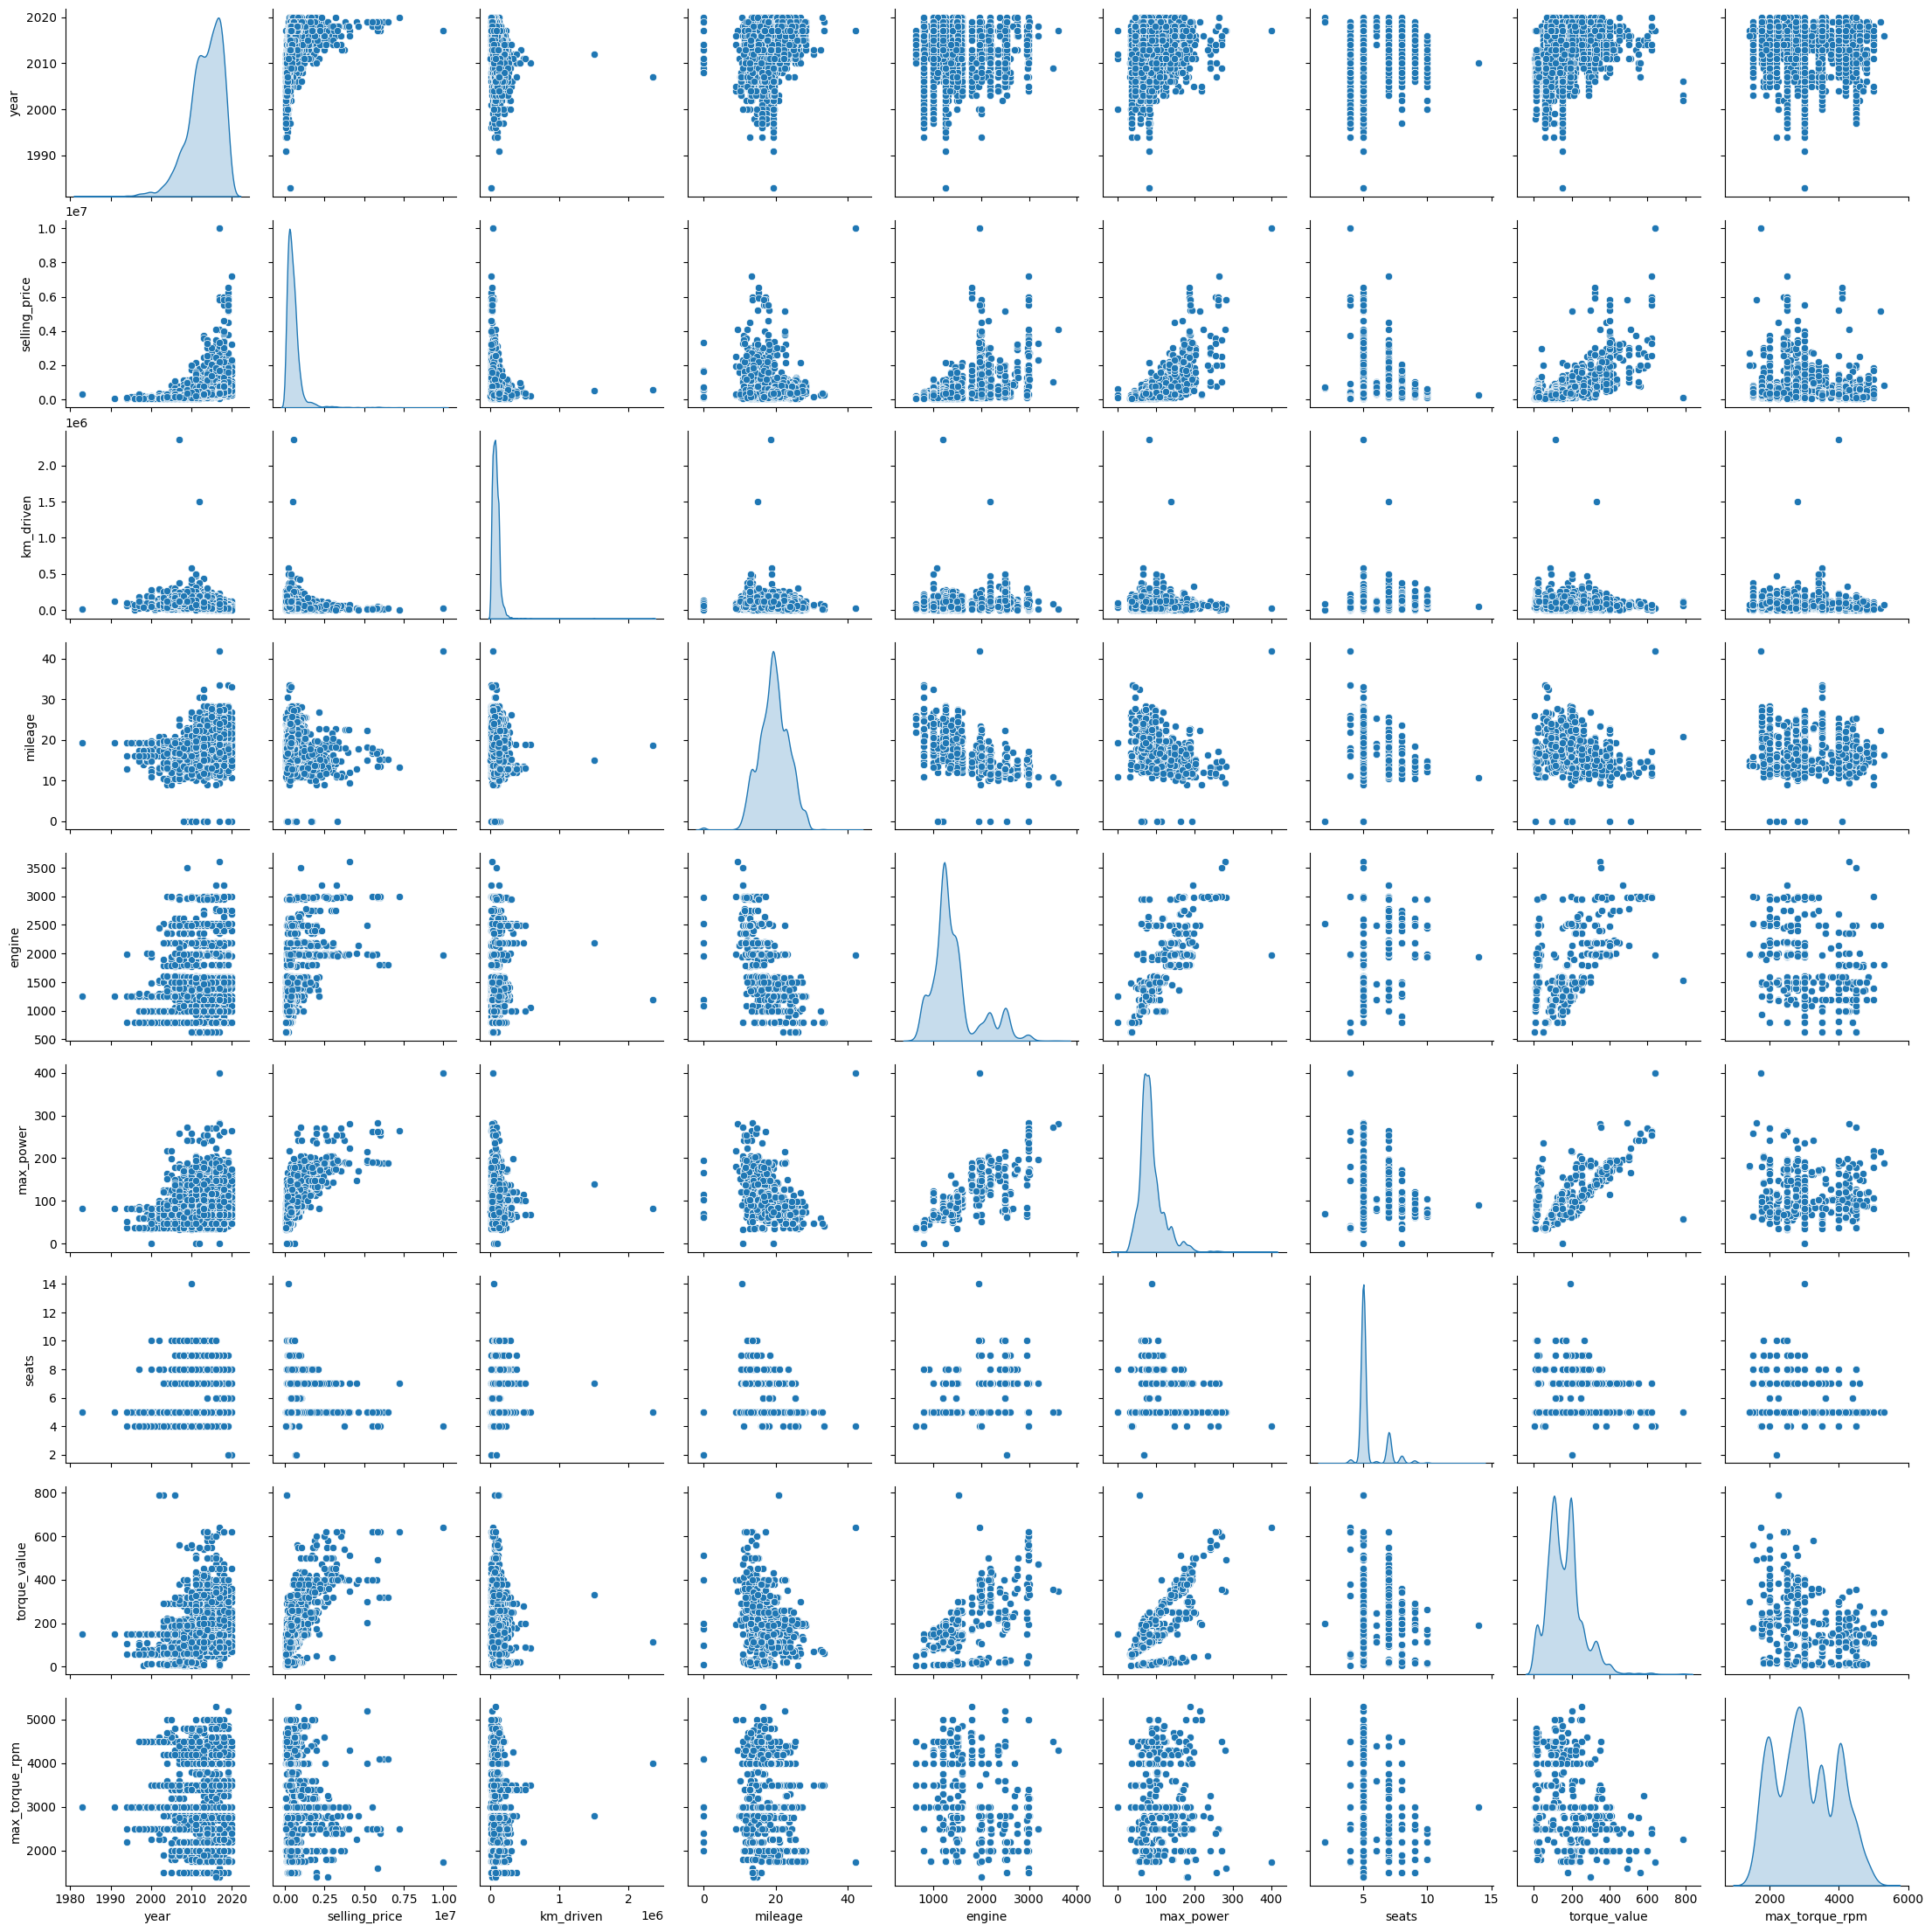

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(df_train[df_train.select_dtypes(include='number').columns], diag_kind='kde')
plt.show()

`По графикам можно увидеть, что max_power и torque_value  имеют почти линейную связь на больших данных. Целевая же переменная имееит не линейную связь с годом, зависимость с km_driven выглядит буд-то есть не линейная зависимость, так же видна корреляция с endgine и max_power. Так же видно выбросы, но удалять мы их не будем.`

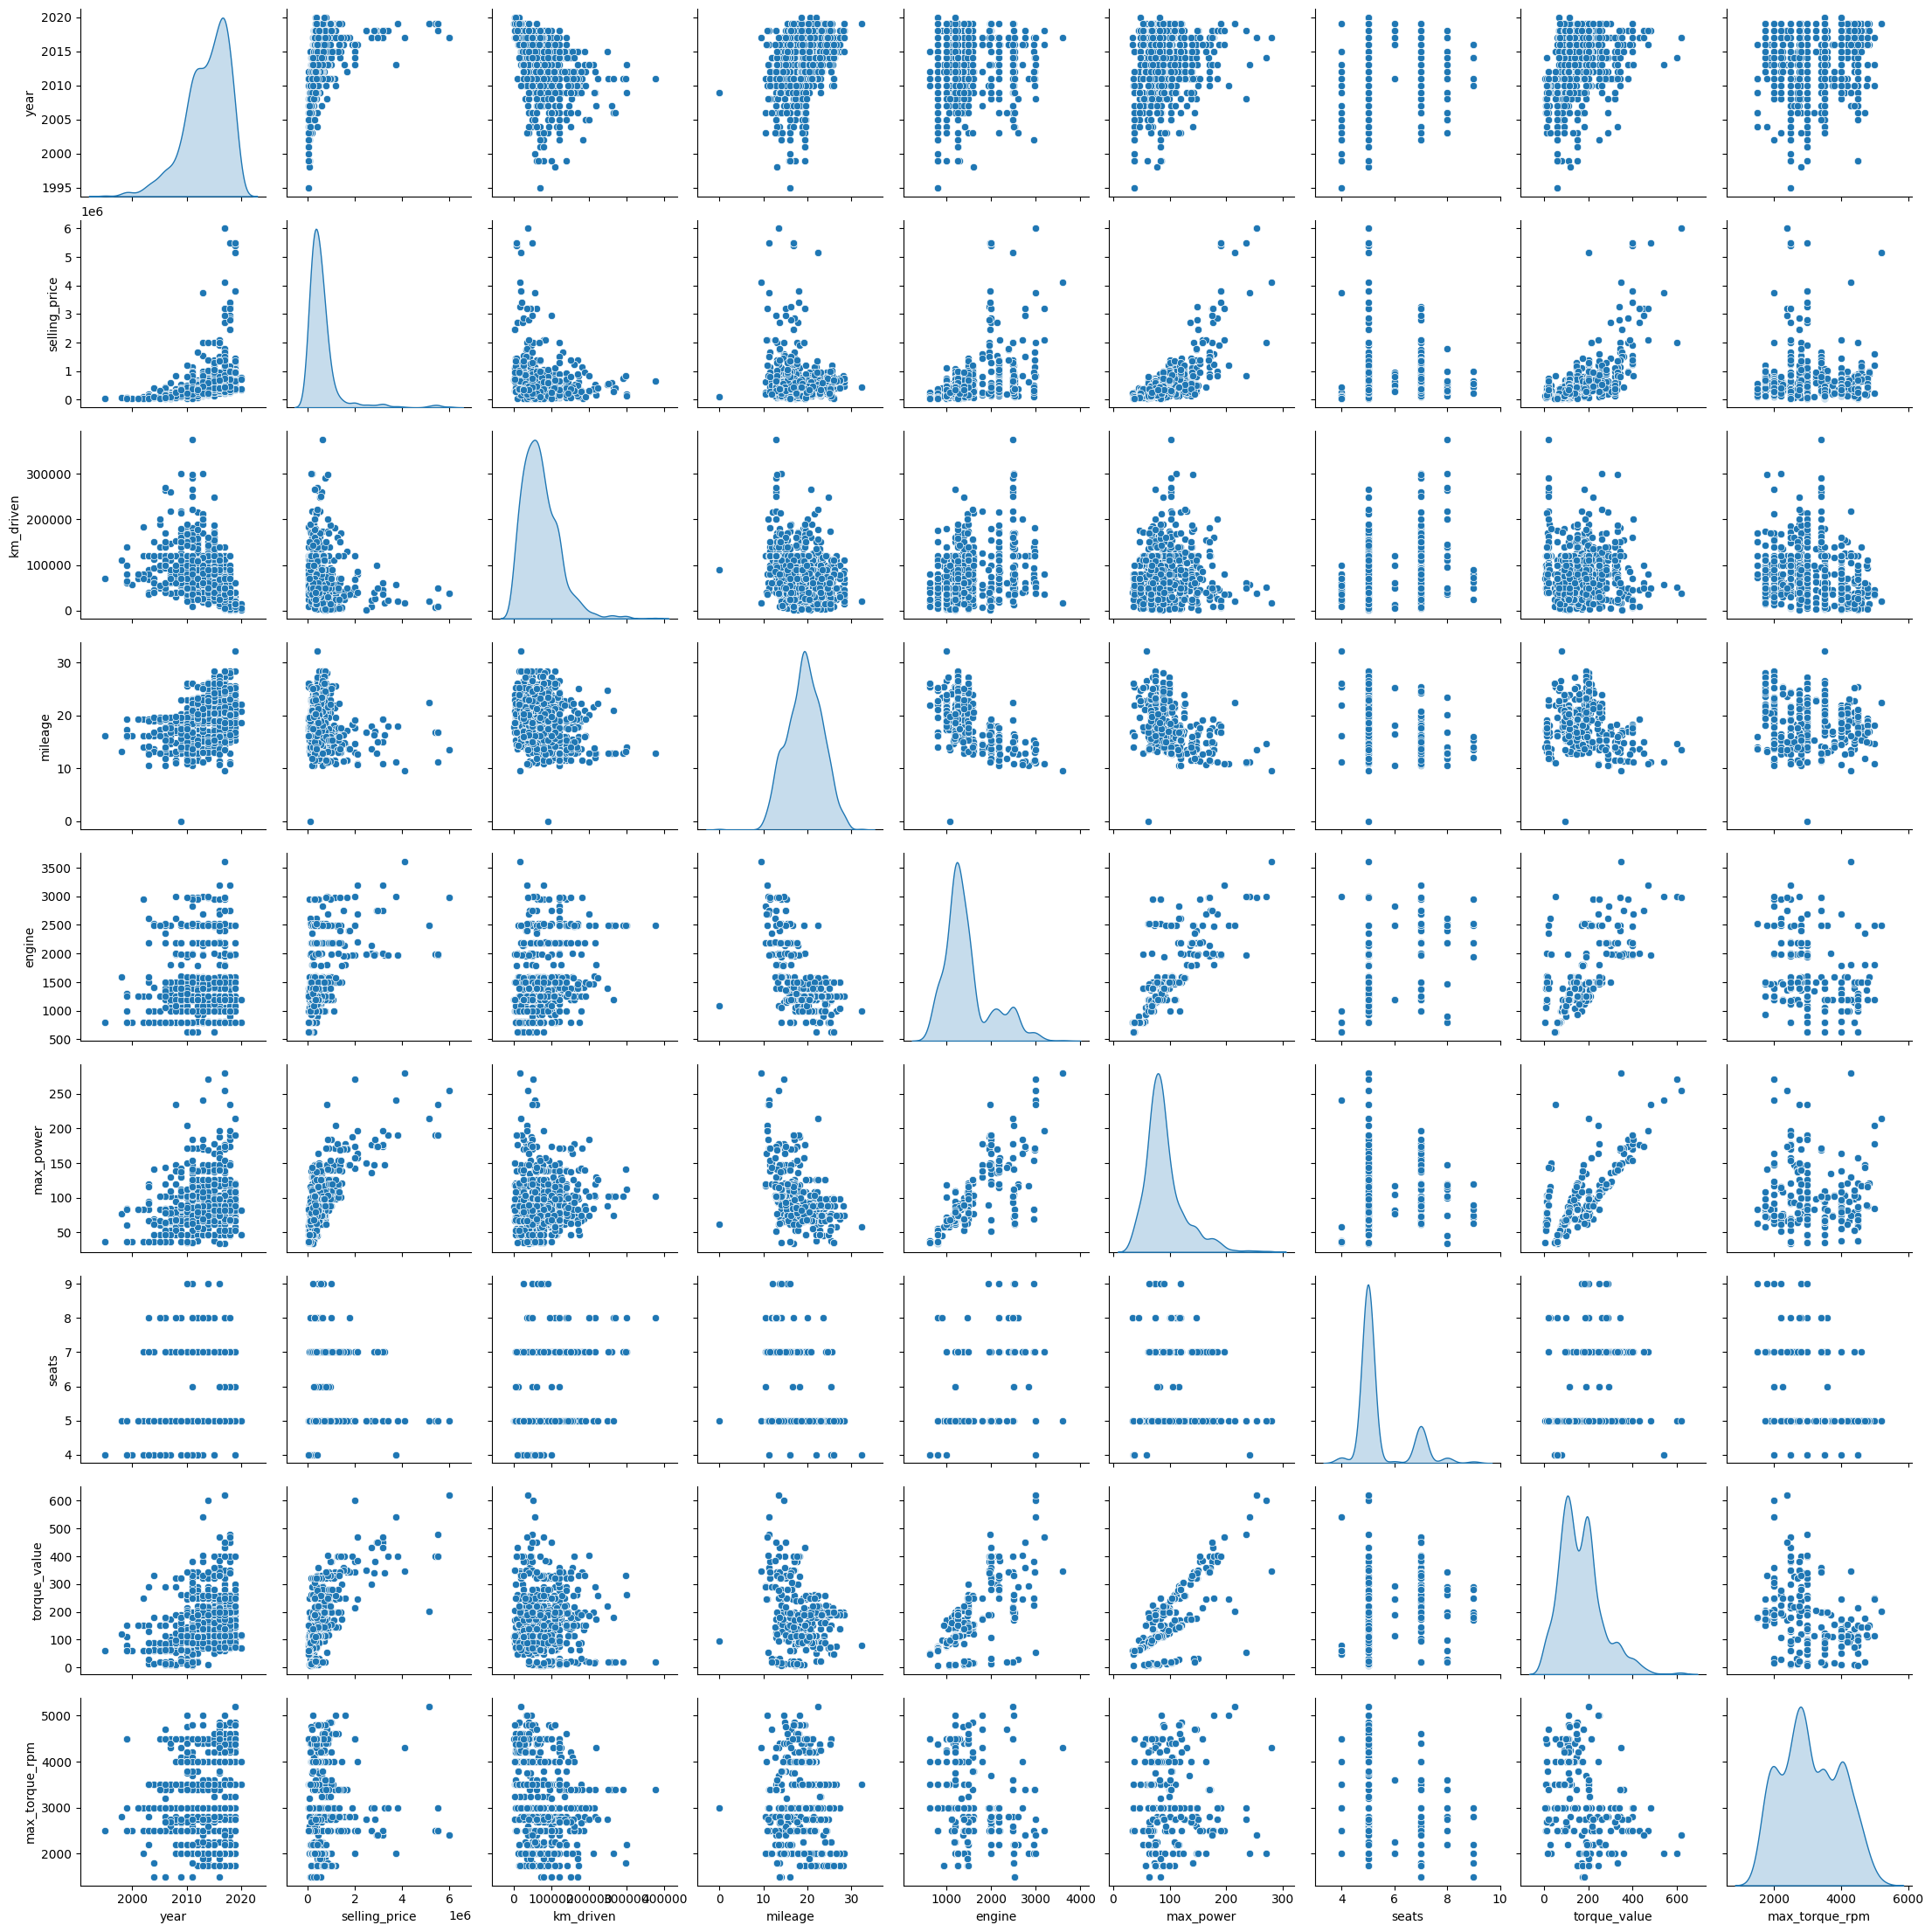

In [225]:
sns.pairplot(df_test[df_test.select_dtypes(include='number').columns], diag_kind='kde')
plt.show()

`совокупности при разделении на трейн и тест оказались похожими`

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [228]:
numerical_features = df_train.select_dtypes(include='number').columns
correlation_matrix = df_train[numerical_features].corr()
display(correlation_matrix)

year  selling_price  km_driven  mileage  engine  max_power  \
year            1.00           0.43      -0.37     0.34    0.00       0.16   
selling_price   0.43           1.00      -0.16    -0.10    0.45       0.69   
km_driven      -0.37          -0.16       1.00    -0.18    0.23       0.02   
mileage         0.34          -0.10      -0.18     1.00   -0.57      -0.37   
engine          0.00           0.45       0.23    -0.57    1.00       0.68   
max_power       0.16           0.69       0.02    -0.37    0.68       1.00   
seats           0.04           0.15       0.19    -0.45    0.65       0.24   
torque_value    0.25           0.61       0.04    -0.13    0.61       0.74   
max_torque_rpm  0.06          -0.09      -0.22    -0.18   -0.26      -0.02   

                seats  torque_value  max_torque_rpm  
year             0.04          0.25            0.06  
selling_price    0.15          0.61           -0.09  
km_driven        0.19          0.04           -0.22  
mileage         -0.45         -0.13           -0.18  
engine           0.65          0.61           -0.26  
max_power        0.24          0.74           -0.02  
seats            1.00          0.31           -0.22  
torque_value     0.31          1.00           -0.40  
max_torque_rpm  -0.22         -0.40            1.00

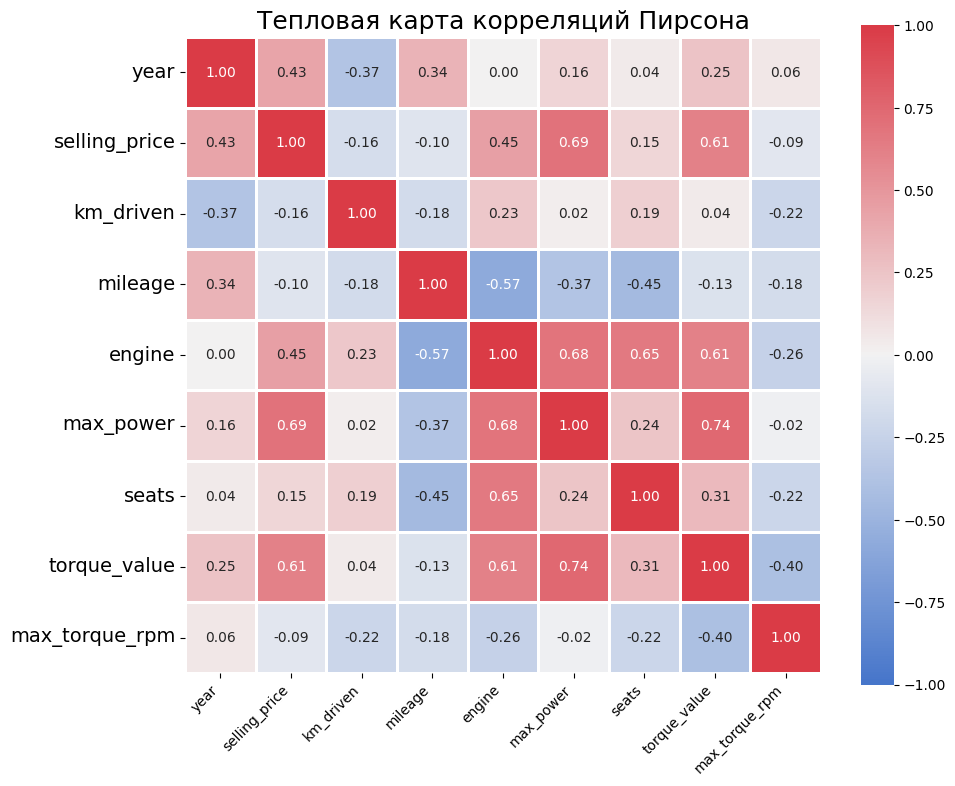

In [229]:
cmap = sns.diverging_palette(255, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    correlation_matrix,
    vmin=-1, vmax=1,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.7},
    cmap=cmap,
    annot=True,
    fmt='.2f',
    linewidths=[-1],
    linecolor='white'
)

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=14)
ax.set_xticklabels(numerical_features, rotation=45, ha='right')
ax.set_title('Тепловая карта корреляций Пирсона', fontsize=18)

plt.tight_layout()
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

`Max_power vs km_driven имеют наименьшую корреляцию. Max_power и torque_value имеют самую сильную положительную корреяцию. Между годом и километражом есть зависимость и в *среднем* чем меньше год, тем больше km_driven`

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ]

Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [233]:
import numpy as np

def spearman_correlation(x, y):
    x = np.array(x)
    y = np.array(y)
    
    if len(x) != len(y):
        raise ValueError("Длинна масивов должна быть одинакова")
    
    x_ranks = np.argsort(np.argsort(x))
    y_ranks = np.argsort(np.argsort(y))
    
    rank_diffs = x_ranks - y_ranks
    
    n = len(x)
    numerator = 6 * np.sum(rank_diffs**2)
    denominator = n * (n**2 - 1)
    spearman_corr = 1 - (numerator / denominator)
    
    return spearman_corr

x = df_train['selling_price'].to_numpy()
y = df_train['km_driven'].to_numpy()
rho = spearman_correlation(x, y)
print(f'Коэффициент корреляции Спирмена: {rho:.2f}')

df_train[['selling_price', 'km_driven']].corr('spearman')

Коэффициент корреляции Спирмена: -0.30


selling_price  km_driven
selling_price           1.00      -0.30
km_driven              -0.30       1.00

In [234]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'torque_value', 'max_torque_rpm']


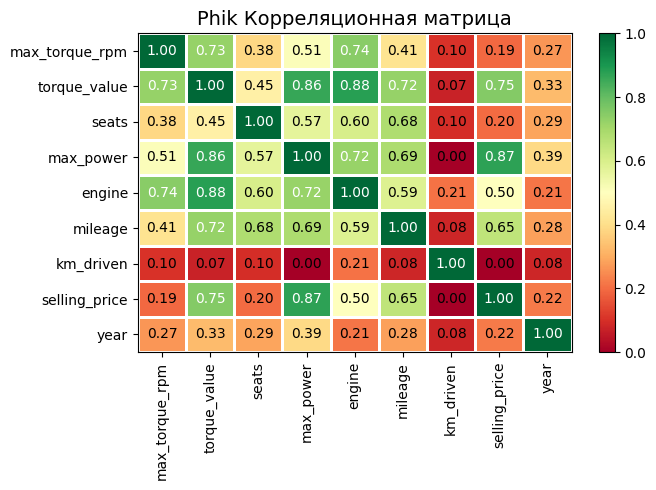

In [235]:
from phik import resources, report
from phik.report import plot_correlation_matrix

phik_matrix = df_train[['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'torque_value', 'max_torque_rpm']].phik_matrix()

plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        vmin=0, vmax=1, title="Phik Корреляционная матрица")
plt.show()

`Целевая переменная selling_price  сильно коррелирует с torque_value, max_powerи mileage. Значения варьируются от 0 (нет связи) до 1 (идеальная связь).`

### **Дополнительные визуализации (бонус 0.2 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.

C:\Users\Ilya\Documents\Ai\aienv\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning:

invalid value encountered in divide



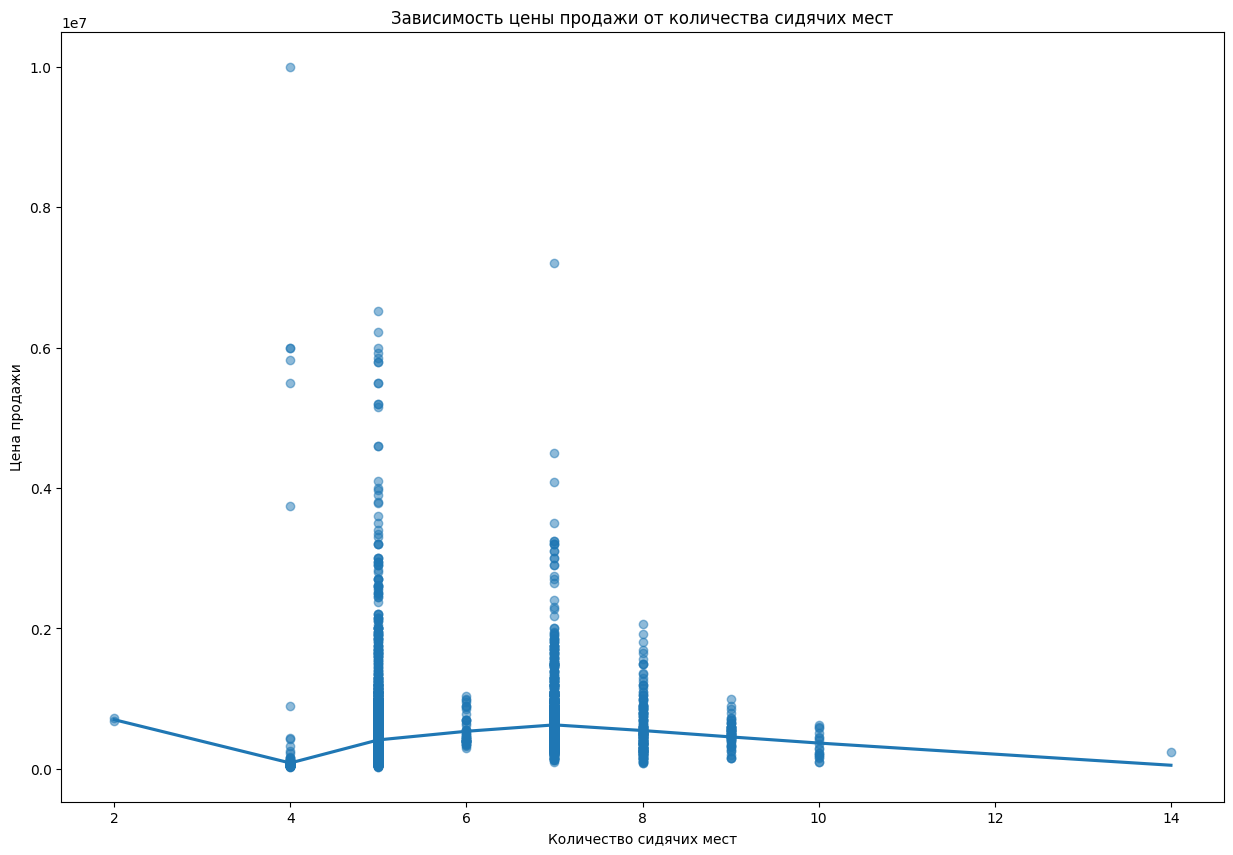

In [238]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.regplot(data=df_train[['seats', 'selling_price',]], x="seats", y="selling_price", scatter_kws={'alpha': 0.5}, order=1, lowess=True)
ax.set_xlabel("Количество сидячих мест")
ax.set_ylabel("Цена продажи")
ax.set_title("Зависимость цены продажи от количества сидячих мест")
plt.show()

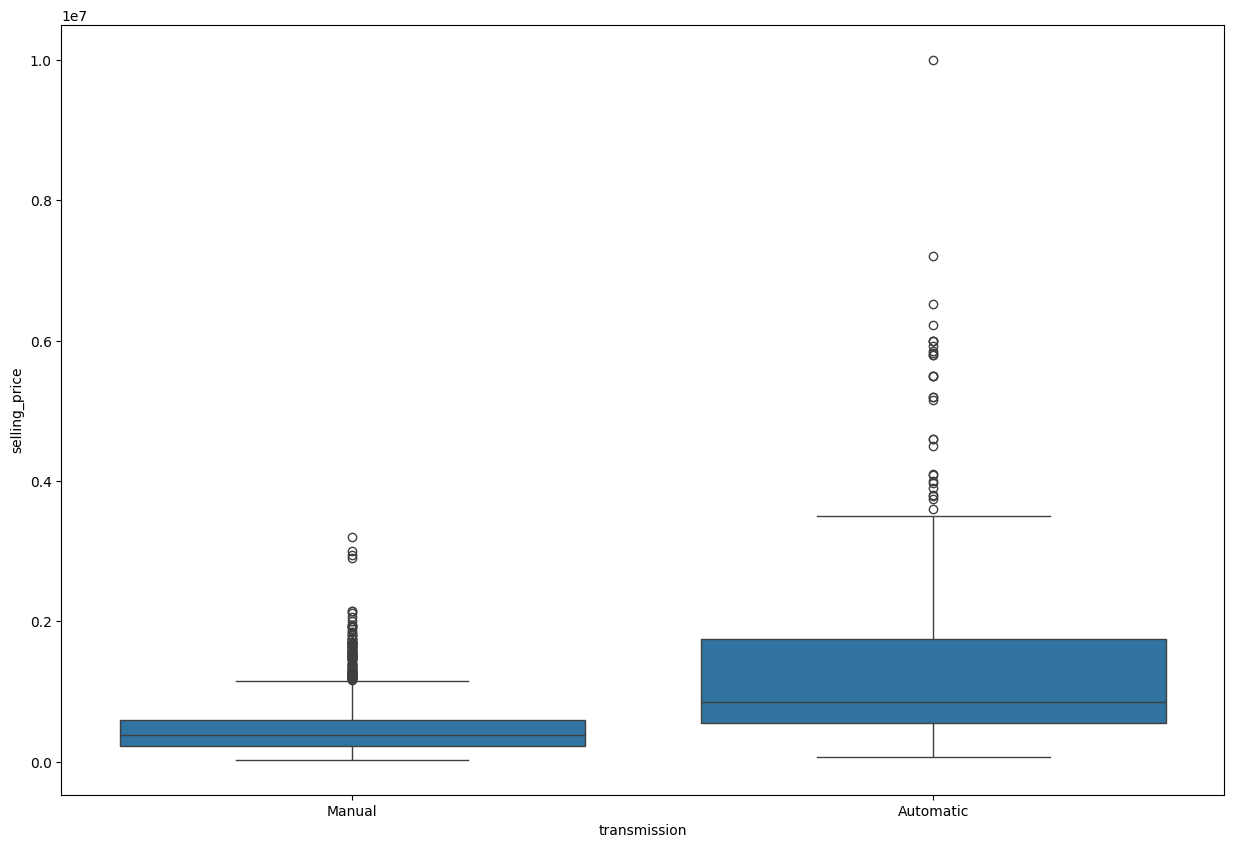

In [239]:
plt.figure(figsize = (15, 10))
sns.boxplot(data = df_train, x = "transmission", y = 'selling_price')
plt.show()

`Автомобили с автоматической коробкой передач стоят сильно больше чем с механической`

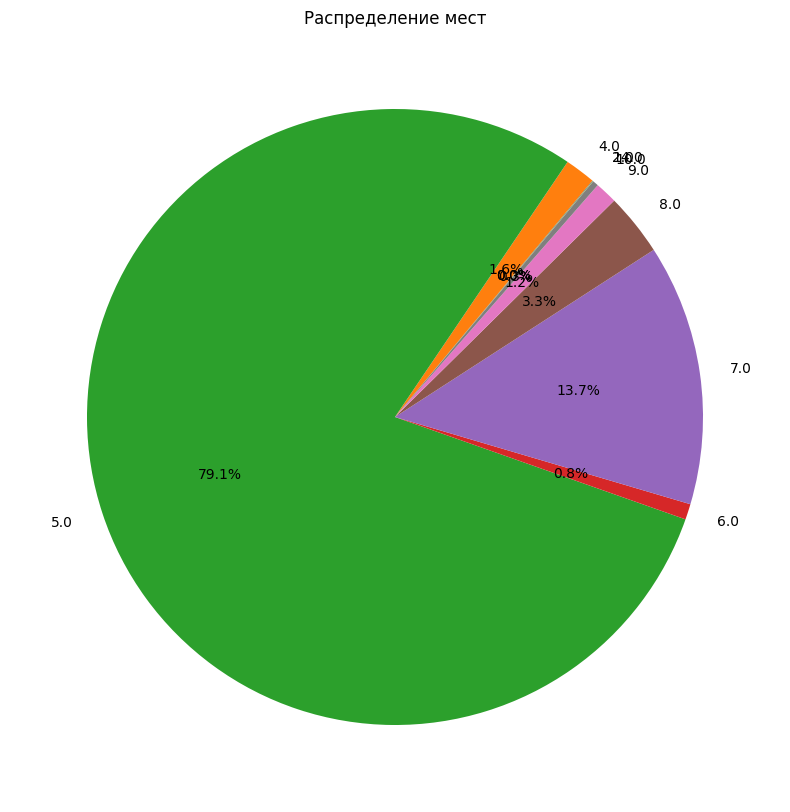

In [241]:
fig, ax = plt.subplots(figsize=(10,10))

values = df_train['seats'].value_counts().sort_index()
labels = values.index

ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=50)

ax.set_title('Распределение мест')

plt.show()

`5-ти местные доминируют, потому что на заднем сидении есть место по середине с ремнем`

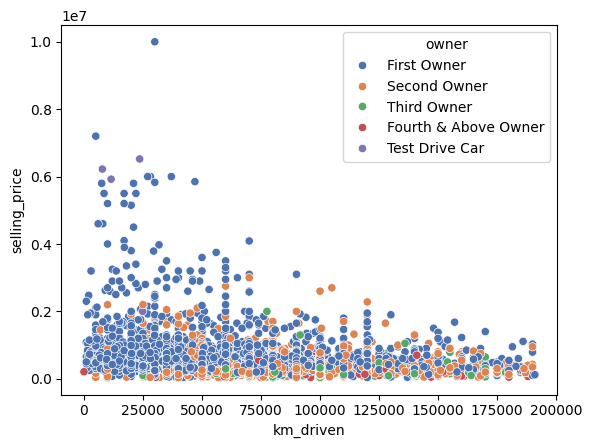

In [243]:
#почистим пробег от выбросов, чтобы была более читаемая визуализация среднего
iqr = df_train['km_driven'].quantile(.75) - df_train['km_driven'].quantile(.25)
low = df_train['km_driven'].quantile(.25) - 1.5 * iqr
high = df_train['km_driven'].quantile(.75) + 1.5 * iqr

km_driven_witout_outlaiers = df_train[['km_driven', 'selling_price', 'owner']][df_train['km_driven'] > low][df_train['km_driven'] < high]

sns.scatterplot(data=km_driven_witout_outlaiers, x="km_driven", y="selling_price", hue="owner", palette="deep")
plt.show()

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [246]:
df_copy = df_train.select_dtypes(include='number').copy()

y_train = df_copy['selling_price']
X_train = df_copy.drop('selling_price', axis=1)

мы добавиляли 2 столбца из torque, так что сейчас изменили assert 6 на 8.

In [248]:
assert X_train.shape == (5840, 8)  

In [249]:
df_copy = df_test.select_dtypes(include='number').copy()
y_test = df_copy['selling_price']
X_test = df_copy.drop('selling_price', axis=1)

In [259]:
assert X_test.shape == (1000, 8)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [262]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error as MSE

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}, RMSE={root_mean_squared_error(y_test, y_pred)}")

r2=0.6012157515457827, MSE=229232573550.3003, RMSE=478782.38642445934


`60% как первый результат неплохо, но по MSE ничего пока не понятно, хотя он и большой RMSE юолее понятен, но он превышает медиану и среднее, так что модель ужасно ошибается.`

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [279]:
def r_squared(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_mean = np.mean(y_true)
    
    ss_tot = np.sum((y_true - y_mean) ** 2)  #квадрат отклонения от среднего (дисперсия)
    
    ss_res = np.sum((y_true - y_pred) ** 2)  #квадрат ошибки модели
    
    r2 = 1 - (ss_res / ss_tot)  #отношение SSR/SST показывает долю дисперсии, объясненную нашей моделью
    return r2

result = r_squared(y_test, y_pred)
print("R^2:", result)

R^2: 0.6012157515457827


`Формула для вычисления R² (коэффициента детерминации) для линейной модели представляет собой единицу минус отношение суммы квадратов остатков регрессии к общей сумме квадратов остатков.`

`В числителе стоит сумма квадратов остатков регрессии (SSres), то есть сумма квадратов разностей между правильным ответом и предсказанным ответом. В знаменателе — общая сумма квадратов остатков (SStot), то есть сумма квадратов разностей между правильным ответом и выборочным средним, где выборочное среднее — это среднее арифметическое всех правильных ответов.`

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [282]:
def adjusted_r_squared(y_true, y_pred, n, k):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_mean = np.mean(y_true)
    
    ss_tot = np.sum((y_true - y_mean) ** 2)
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    adjusted_r2 = 1 - ((1 - r_squared) * (n - 1)) / (n - k - 1)
    
    return adjusted_r2

n = len(y_test)            # Количество наблюдений
k = 2                      # Количество предикторов в модели

result = adjusted_r_squared(y_test, y_pred, n, k)
print("Adjusted R^2:", result)

Adjusted R^2: 0.6004157831436678


`Adjusted R-squared представляет собой обычный R-квадрат, но со штрафом за большое количество предикторов. Она указывает на то, что модель хорошо описывает данные без включения ненужных предикторов, что выбранные переменные значимы и вносят вклад в объяснение вариабельности зависимой переменной. Низкое или отрицательное значение Adjusted R-squared говорит о том, что добавление новых предикторов не улучшает качество модели и может даже навредить ей.`

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [285]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}")

r2=0.6012157515457826, MSE=229232573550.30038


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [287]:
num_col = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'torque_value', 'max_torque_rpm']
data_fut_imp = pd.DataFrame(data={'score': list(map(abs, lr.coef_.tolist()))}, index = num_col)
importances_col = data_fut_imp.sort_values(by='score', ascending = False)
importances_col

score
max_power      308649.34
year           161940.65
max_torque_rpm  52077.85
km_driven       49225.06
torque_value    37093.80
seats           32543.31
engine          16677.21
mileage         15044.52

In [288]:
import plotly.graph_objects as go
fig = go.Figure([go.Bar(x=importances_col.index, y=importances_col.score)])

fig.update_layout(height = 800, width = 1000, title = 'Важность признаков', titlefont={'size': 30})

fig.show()

`max_power, year, max_torque_rpm, km_driven оказались самымм информативными`

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [291]:
from sklearn.linear_model import Lasso

lr = Lasso()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}")

r2=0.6012144837443134, MSE=229233302318.78775


In [292]:
lr.coef_

array([161938.261, -49224.099, -15041.045,  16675.243, 308650.029,
       -32539.3  ,  37094.306, -52075.277])

In [293]:
data_fut_imp = pd.DataFrame(data={'score': list(map(abs, lr.coef_.tolist()))}, index = num_col)
importances_col = data_fut_imp.sort_values(by='score', ascending = False)

fig = go.Figure([go.Bar(x=importances_col.index, y=importances_col.score)])

fig.update_layout(height = 800, width = 1000, title = 'Важность признаков', titlefont={'size': 30})

fig.show()

`Значения не занулились, потому что параметры между собой не взаимо заменимы`

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [296]:
%%time

from sklearn.model_selection import GridSearchCV

params = {"alpha": np.arange(0.0001, 1, 0.05)
            }

grid = GridSearchCV(Lasso(), param_grid = params, cv = 10, scoring="r2", n_jobs=1)
grid.fit(X_train, y_train)

CPU times: total: 594 ms
Wall time: 597 ms


GridSearchCV(cv=10, estimator=Lasso(), n_jobs=1,
             param_grid={'alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='r2')

In [297]:
best_params = grid.best_params_
best_score = grid.best_score_
print("Лучшие параметры:", best_params)
print("Лучший балл:", best_score)

Лучшие параметры: {'alpha': 0.9001}
Лучший балл: 0.5767470435235851


In [298]:
len(np.arange(0.0001, 1, 0.05))

20

`Количество обучаемых моделей зависит от количества параметров в сетке и числа фолдов. грид-сёрчу пришлось обучать моделей 20*10 = 200`

`Параметр alpha это параметр регуляризации в Lasso-регрессии. Он управляет степенью штрафа, накладываемого на коэффициенты модели. Чем больше значение alpha, тем сильнее будет регуляризация и тем больше коэффициентов может стать нулевыми.`

In [301]:
best_model = grid.best_estimator_
coefficients = best_model.coef_
nonzero_coefficients = sum(coefficients != 0)
zero_coefficients = len(coefficients) - nonzero_coefficients
print("Ненулевых коэффициентов:", nonzero_coefficients)
print("Нулевых коэффициентов:", zero_coefficients)

Ненулевых коэффициентов: 8
Нулевых коэффициентов: 0


In [302]:
best_model.coef_

array([161938.496, -49224.196, -15041.388,  16675.436, 308649.961,
       -32539.697,  37094.259, -52075.531])

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [304]:
%%time
from sklearn.linear_model import ElasticNet

params = {"alpha": np.arange(0.0001, 1, 0.05),
          "l1_ratio": np.arange(0.0001, 1, 0.05)
            }

grid = GridSearchCV(ElasticNet(), params, cv = 10, scoring="r2")
grid.fit(X_train, y_train)

CPU times: total: 10.3 s
Wall time: 10.3 s


GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='r2')

In [305]:
best_params = grid.best_params_
best_score = grid.best_score_
print("Лучшие параметры:", best_params)
print("Лучший балл:", best_score)

Лучшие параметры: {'alpha': 0.5501, 'l1_ratio': 0.7501}
Лучший балл: 0.5830243069918437


In [306]:
y_pred = grid.predict(X_test) 

print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}, RMSE={root_mean_squared_error(y_test, y_pred)}")

r2=0.5744085036925475, MSE=244642145114.41727, RMSE=494613.126710581


In [307]:
len(np.arange(0.0001, 1, 0.05))

20

`Количество обучаемых моделей зависит от количества комбинаций параметров в сетке и числа фолдов. 20 * 20 Поскольку используется 10 фолдов, общее количество обученных моделей равно 4000`

`Гиперпараметры лучшей модели можно увидеть в результате best_params. Эти параметры включают значения alpha и l1_ratio, которые привели к наилучшему качеству модели согласно выбранной метрике.`

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [314]:
df_train.name.str.split().str.len().value_counts()  # посчитали количество слов в названии

name
4     1909
5     1501
3      951
6      911
7      420
8       99
9       44
10       5
Name: count, dtype: int64

In [315]:
df_train[df_train.name.str.split().str.len() == 10]

name  year  selling_price  \
212     Toyota Innova 2.5 EV (Diesel) PS 7 Seater BS IV  2013         700000   
815     Toyota Innova 2.5 EV (Diesel) PS 8 Seater BS IV  2013         850000   
3524  Tata Indica Vista Aura 1.2 Safire (ABS) 90hp B...  2010         150000   
4132  Tata Indica Vista Aura 1.2 Safire (ABS) 90hp B...  2011         150000   
4228    Toyota Innova 2.5 EV (Diesel) PS 7 Seater BS IV  2013         625000   

      km_driven    fuel seller_type transmission         owner  mileage  \
212       70000  Diesel  Individual       Manual   First Owner    12.99   
815      120000  Diesel  Individual       Manual  Second Owner    12.99   
3524      29000  Petrol  Individual       Manual   First Owner    16.50   
4132      70000  Petrol  Individual       Manual  Second Owner    16.50   
4228     100000  Diesel  Individual       Manual  Second Owner    12.99   

      engine  max_power  seats  torque_value  max_torque_rpm  
212  2494.00     100.57   7.00        200.00            3400  
815  2494.00     100.57   8.00        200.00            3400  
3524 1172.00      65.00   5.00         96.00            3000  
4132 1172.00      65.00   5.00         96.00            3000  
4228 2494.00     100.57   7.00        200.00            3400

In [316]:
df_train.loc[:, 'mark'] = df_train.name.str.split().str[0]
df_train.loc[:, 'model'] = df_train.name.str.split().str[1]


df_test.loc[:, 'mark'] = df_test.name.str.split().str[0]
df_test.loc[:, 'model'] = df_test.name.str.split().str[1]

In [317]:
df_train

name  year  selling_price  km_driven  \
0                Maruti Swift Dzire VDI  2014         450000     145500   
1          Skoda Rapid 1.5 TDI Ambition  2014         370000     120000   
2             Hyundai i20 Sportz Diesel  2010         225000     127000   
3                Maruti Swift VXI BSIII  2007         130000     120000   
4         Hyundai Xcent 1.2 VTVT E Plus  2017         440000      45000   
...                                 ...   ...            ...        ...   
5835            Hyundai Santro Xing GLS  2008         120000     191000   
5836  Maruti Wagon R VXI BS IV with ABS  2013         260000      50000   
5837                  Hyundai i20 Magna  2013         320000     110000   
5838              Hyundai Verna CRDi SX  2007         135000     119000   
5839             Maruti Swift Dzire ZDi  2009         382000     120000   

        fuel seller_type transmission                 owner  mileage  engine  \
0     Diesel  Individual       Manual           First Owner    23.40 1248.00   
1     Diesel  Individual       Manual          Second Owner    21.14 1498.00   
2     Diesel  Individual       Manual           First Owner    23.00 1396.00   
3     Petrol  Individual       Manual           First Owner    16.10 1298.00   
4     Petrol  Individual       Manual           First Owner    20.14 1197.00   
...      ...         ...          ...                   ...      ...     ...   
5835  Petrol  Individual       Manual           First Owner    17.92 1086.00   
5836  Petrol  Individual       Manual          Second Owner    18.90  998.00   
5837  Petrol  Individual       Manual           First Owner    18.50 1197.00   
5838  Diesel  Individual       Manual  Fourth & Above Owner    16.80 1493.00   
5839  Diesel  Individual       Manual           First Owner    19.30 1248.00   

      max_power  seats  torque_value  max_torque_rpm     mark   model  
0         74.00   5.00        190.00            2000   Maruti   Swift  
1        103.52   5.00        250.00            2500    Skoda   Rapid  
2         90.00   5.00         22.40            2750  Hyundai     i20  
3         88.20   5.00         11.50            4500   Maruti   Swift  
4         81.86   5.00        113.75            4000  Hyundai   Xcent  
...         ...    ...           ...             ...      ...     ...  
5835      62.10   5.00         96.10            3000  Hyundai  Santro  
5836      67.10   5.00         90.00            3500   Maruti   Wagon  
5837      82.85   5.00        113.70            4000  Hyundai     i20  
5838     110.00   5.00         24.00            2750  Hyundai   Verna  
5839      73.90   5.00        190.00            2000   Maruti   Swift  

[5840 rows x 16 columns]

In [318]:
df_train[df_train.name.str.contains('TDI')]  # 1 марка 2 модель

name  year  selling_price  \
1                  Skoda Rapid 1.5 TDI Ambition  2014         370000   
51                   Audi A6 2.0 TDI Technology  2013        1750000   
52              Audi A6 2.0 TDI  Design Edition  2013        1689999   
60    Volkswagen Ameo 1.5 TDI Highline 16 Alloy  2016         540000   
63          Volkswagen Ameo 1.5 TDI Comfortline  2017         500000   
...                                         ...   ...            ...   
5634           Tata Indica Vista Aqua TDI BSIII  2011         200000   
5635       Audi Q3 2.0 TDI Quattro Premium Plus  2014        1200000   
5648  Volkswagen Ameo 1.5 TDI Highline 16 Alloy  2017         650000   
5654           Volkswagen Polo 1.5 TDI Highline  2014         391000   
5762             Tata Indigo CS LX (TDI) BS III  2008         100000   

      km_driven    fuel seller_type transmission         owner  mileage  \
1        120000  Diesel  Individual       Manual  Second Owner    21.14   
51        33900  Diesel      Dealer    Automatic  Second Owner    17.68   
52        50000  Diesel      Dealer    Automatic   First Owner    18.53   
60        40000  Diesel  Individual       Manual   First Owner    22.00   
63        80000  Diesel  Individual       Manual   First Owner    21.66   
...         ...     ...         ...          ...           ...      ...   
5634     200000  Diesel  Individual       Manual  Second Owner    17.00   
5635     230000  Diesel  Individual    Automatic   First Owner    15.73   
5648      49060  Diesel  Individual       Manual   First Owner    22.00   
5654     120000  Diesel  Individual       Manual  Second Owner    20.14   
5762     120000  Diesel  Individual       Manual   First Owner    19.09   

      engine  max_power  seats  torque_value  max_torque_rpm        mark  \
1    1498.00     103.52   5.00        250.00            2500       Skoda   
51   1968.00     174.33   5.00        380.00            2500        Audi   
52   1968.00     187.74   5.00        400.00            3000        Audi   
60   1498.00     108.50   5.00        250.00            3000  Volkswagen   
63   1498.00     108.62   5.00        250.00            3000  Volkswagen   
...      ...        ...    ...           ...             ...         ...   
5634 1405.00      71.00   5.00        135.00            2500        Tata   
5635 1968.00     174.33   5.00        380.00            2500        Audi   
5648 1498.00     108.50   5.00        250.00            3000  Volkswagen   
5654 1498.00      88.80   5.00        230.00            2500  Volkswagen   
5762 1396.00      69.00   5.00        135.00            2500        Tata   

       model  
1      Rapid  
51        A6  
52        A6  
60      Ameo  
63      Ameo  
...      ...  
5634  Indica  
5635      Q3  
5648    Ameo  
5654    Polo  
5762  Indigo  

[194 rows x 16 columns]

In [319]:
df_train = df_train.drop('name', axis=1)

In [320]:
df_train.dtypes

year                int64
selling_price       int64
km_driven           int64
fuel               object
seller_type        object
transmission       object
owner              object
mileage           float64
engine            float64
max_power         float64
seats             float64
torque_value      float64
max_torque_rpm      Int64
mark               object
model              object
dtype: object

In [321]:
cat_col = ['fuel', 'seller_type', 'transmission', 'owner', 'mark', 'model', 'seats']

In [380]:
X_train_cat = df_train[cat_col]
X_test_cat = df_test[cat_col]

In [382]:
X_train_cat.loc[:, 'seats'] = X_train_cat.seats.astype('Int64').astype('O')
X_test_cat.loc[:, 'seats'] = X_test_cat.seats.astype('Int64').astype('O')

C:\Users\Ilya\AppData\Local\Temp\ipykernel_18600\3894384411.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[5 5 5 ... 5 5 5]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

C:\Users\Ilya\AppData\Local\Temp\ipykernel_18600\3894384411.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7 5 5 5 5 6 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 4 5 5 5 7 5 5 7 5 8 5 5 5 5
 5 7 5 5 5 5 5 5 7 5 5 7 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5
 7 5 5 5 5 7 7 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 7 7 5 5 5 5 5 5 5 5 7 5 5 5
 5 5 7 5 5 4 5 5 5 7 5 5 5 5 5 5 5 7 5 5 5 5 7 5 7 5 7 5 7 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 7 7 5 5 5 5 5 5 5 5 7 5 5 5 7 5 7 5 5 5 5 7 5 5 5 5 7 5 5 7 5
 7 8 5 5 5 5 5 5 5 5 4 5 8 5 9 5 5 5 5 5 5 5 8 5 5 5 5 6 5 5 8 5 5 7 5 5 5
 5 5 5 5 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 7 7 8 5 5 7 5 9 7 

In [384]:
X_train_cat.dtypes

fuel            object
seller_type     object
transmission    object
owner           object
mark            object
model           object
seats           object
dtype: object

In [386]:
assert X_train_cat.shape == (5840, 7)

In [327]:
X_train_cat.describe(include='object')

fuel seller_type transmission        owner    mark  model  seats
count     5840        5840         5840         5840    5840   5840   5840
unique       4           3            2            5      30    202      9
top     Diesel  Individual       Manual  First Owner  Maruti  Swift      5
freq      3177        5223         5336         3603    1804    558   4618

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [398]:
from sklearn.preprocessing import OneHotEncoder # или можно использовать get_dummies из библиотеки pandas
cat_col = ['fuel', 'seller_type', 'transmission', 'owner', 'mark', 'model', 'seats']
ohe = OneHotEncoder()
ohe.fit(pd.concat([X_train_cat, X_test_cat]))
X_train_cat = pd.concat([X_train_cat, pd.DataFrame(ohe.transform(X_train_cat[cat_col]).toarray())], axis = 1)
X_test_cat = pd.concat([X_test_cat, pd.DataFrame(ohe.transform(X_test_cat[cat_col]).toarray())], axis = 1)

In [402]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(ohe, f)

In [136]:
X_train_cat = X_train_cat.drop(cat_col, axis = 1)
X_test_cat = X_test_cat.drop(cat_col, axis = 1)

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`Убедитесь, что категориальные признаки имеют разумное количество уникальных значений. OHE не подходит для признаков с большим количеством уникальных категорий, так как это приведет к увеличению размерности данных`

`При OHE для каждой категории создается бинарный столбец. Однако, если категориальный признак принимает nn значений, то nn-й столбец всегда однозначно определяется первыми n−1n−1. Это явление называется мультколлинеарностью`

`Удаление признаков, которые оказались незначимыми по весам модели, может быть корректным, если признаки коррелируют с другими, веса модели дают только общую оценку значимости признаков, Удаление неважных признаков уменьшает размерность, что полезно для борьбы с переобучением`

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [142]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

params = {"alpha": np.arange(0.0001, 1, 0.05)}

grid = GridSearchCV(Ridge(), params, cv = 10, scoring="r2")
grid.fit(X_train_cat, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='r2')

In [143]:
X_train_cat.dtypes

0      float64
1      float64
2      float64
3      float64
4      float64
        ...   
257    float64
258    float64
259    float64
260    float64
261    float64
Length: 262, dtype: object

In [144]:
np.arange(0.0001, 1, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [145]:
best_params = grid.best_params_
best_score = grid.best_score_
print("Лучшие параметры:", best_params)
print("Лучший балл:", best_score)

Лучшие параметры: {'alpha': 0.2501}
Лучший балл: 0.7049588278256713


In [146]:
y_pred = grid.predict(X_test_cat) 

print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}, RMSE={root_mean_squared_error(y_test, y_pred)}")

r2=0.8851667942443661, MSE=66009405803.843346, RMSE=256922.9569420439


In [147]:
lr = Ridge(alpha = 0.1501)
lr.fit(X_train_cat, y_train)
y_pred = lr.predict(X_test_cat)
print(f"r2={r2_score(y_test, y_pred)}, MSE={MSE(y_test, y_pred)}, RMSE={root_mean_squared_error(y_test, y_pred)}")

r2=0.884617014662382, MSE=66325434806.87476, RMSE=257537.24935798076


In [148]:
import pickle
with open('model.pickle', 'wb') as fp:
    pickle.dump(lr, fp)

`Да удалось, r2, стало лучше, RMSE сильно меньше, но в нашей ситуации при заданных параметрах не удалось найти самый оптимальный коэффициент на сетке. Одной из причин может быть использования недостаточного количества повторений кросс-валидации` 

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 2-х баллов в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [152]:
df_train["year_2"] = df_train.year ** 2
df_train["km_driven/year"] = df_train["km_driven"]/-(df_train["year"]-2022)
df_train

year  selling_price  km_driven    fuel seller_type transmission  \
0     2014         450000     145500  Diesel  Individual       Manual   
1     2014         370000     120000  Diesel  Individual       Manual   
2     2010         225000     127000  Diesel  Individual       Manual   
3     2007         130000     120000  Petrol  Individual       Manual   
4     2017         440000      45000  Petrol  Individual       Manual   
...    ...            ...        ...     ...         ...          ...   
5835  2008         120000     191000  Petrol  Individual       Manual   
5836  2013         260000      50000  Petrol  Individual       Manual   
5837  2013         320000     110000  Petrol  Individual       Manual   
5838  2007         135000     119000  Diesel  Individual       Manual   
5839  2009         382000     120000  Diesel  Individual       Manual   

                     owner  mileage  engine  max_power  seats  torque_value  \
0              First Owner    23.40 1248.00      74.00   5.00        190.00   
1             Second Owner    21.14 1498.00     103.52   5.00        250.00   
2              First Owner    23.00 1396.00      90.00   5.00         22.40   
3              First Owner    16.10 1298.00      88.20   5.00         11.50   
4              First Owner    20.14 1197.00      81.86   5.00        113.75   
...                    ...      ...     ...        ...    ...           ...   
5835           First Owner    17.92 1086.00      62.10   5.00         96.10   
5836          Second Owner    18.90  998.00      67.10   5.00         90.00   
5837           First Owner    18.50 1197.00      82.85   5.00        113.70   
5838  Fourth & Above Owner    16.80 1493.00     110.00   5.00         24.00   
5839           First Owner    19.30 1248.00      73.90   5.00        190.00   

      max_torque_rpm     mark   model   year_2  km_driven/year  
0               2000   Maruti   Swift  4056196        18187.50  
1               2500    Skoda   Rapid  4056196        15000.00  
2               2750  Hyundai     i20  4040100        10583.33  
3               4500   Maruti   Swift  4028049         8000.00  
4               4000  Hyundai   Xcent  4068289         9000.00  
...              ...      ...     ...      ...             ...  
5835            3000  Hyundai  Santro  4032064        13642.86  
5836            3500   Maruti   Wagon  4052169         5555.56  
5837            4000  Hyundai     i20  4052169        12222.22  
5838            2750  Hyundai   Verna  4028049         7933.33  
5839            2000   Maruti   Swift  4036081         9230.77  

[5840 rows x 17 columns]

In [153]:
df_test["year_2"] = df_test.year ** 2
df_test["km_driven/year"] = df_test["km_driven"]/-(df_test["year"]-2022)
df_test

name  year  selling_price  km_driven  \
0                    Mahindra Xylo E4 BS IV  2010         229999     168000   
1                Tata Nexon 1.5 Revotorq XE  2017         665000      25000   
2                      Honda Civic 1.8 S AT  2007         175000     218463   
3                      Honda City i DTEC VX  2015         635000     173000   
4    Tata Indica Vista Aura 1.2 Safire BSIV  2011         130000      70000   
..                                      ...   ...            ...        ...   
995                  Hyundai i10 Magna 1.1L  2008         250000     100000   
996        Hyundai i20 2015-2017 Sportz 1.2  2017         440000      50000   
997                  Hyundai i20 Era Diesel  2009         340000      40000   
998                        Hyundai i10 Asta  2012         350000      25000   
999                    Honda City i DTec SV  2016         700000     110000   

       fuel seller_type transmission         owner  mileage  engine  \
0    Diesel  Individual       Manual   First Owner    14.00 2498.00   
1    Diesel  Individual       Manual   First Owner    21.50 1497.00   
2    Petrol  Individual    Automatic   First Owner    12.90 1799.00   
3    Diesel  Individual       Manual   First Owner    25.10 1498.00   
4    Petrol  Individual       Manual  Second Owner    16.50 1172.00   
..      ...         ...          ...           ...      ...     ...   
995  Petrol  Individual       Manual  Second Owner    19.81 1086.00   
996  Petrol  Individual       Manual  Second Owner    18.60 1197.00   
997  Diesel  Individual       Manual   First Owner    23.00 1396.00   
998  Petrol  Individual       Manual   First Owner    20.36 1197.00   
999  Diesel  Individual       Manual   First Owner    26.00 1498.00   

     max_power  seats  torque_value  max_torque_rpm      mark   model  \
0       112.00   7.00        260.00            2200  Mahindra    Xylo   
1       108.50   5.00        260.00            2750      Tata   Nexon   
2       130.00   5.00        172.00            4300     Honda   Civic   
3        98.60   5.00        200.00            1750     Honda    City   
4        65.00   5.00         96.00            3000      Tata  Indica   
..         ...    ...           ...             ...       ...     ...   
995      68.05   5.00         99.04            4500   Hyundai     i10   
996      81.83   5.00        114.70            4000   Hyundai     i20   
997      90.00   5.00         22.40            2750   Hyundai     i20   
998      78.90   5.00        111.80            4000   Hyundai     i10   
999      98.60   5.00        200.00            1750     Honda    City   

      year_2  km_driven/year  
0    4040100        14000.00  
1    4068289         5000.00  
2    4028049        14564.20  
3    4060225        24714.29  
4    4044121         6363.64  
..       ...             ...  
995  4032064         7142.86  
996  4068289        10000.00  
997  4036081         3076.92  
998  4048144         2500.00  
999  4064256        18333.33  

[1000 rows x 18 columns]

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [156]:
def business_metric(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Размеры массивов должны совпадать.")
    
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_value, pred_value in zip(y_true, y_pred):
        error_percentage = abs(true_value - pred_value) / true_value * 100
        
        if error_percentage <= 10:
            correct_predictions += 1
            
    return correct_predictions / total_predictions

In [157]:
def business_metrics(y_true, y_pred):
    counter = 0
    n = len(y_true)
    counter = sum([1 if np.abs((y_pred[i]*100 / y_true.values[i]) - 100) > 10 else 0 for i in range(n)])

    return (counter / n) *100

print('Доля неправильных прогнозов', business_metrics(y_test, y_pred))

Доля неправильных прогнозов 72.89999999999999


In [158]:
metric_result = business_metric(y_test, y_pred)
print(f"Доля правильных прогнозов: {metric_result:.2f}")

Доля правильных прогнозов: 0.27


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [160]:
def your_business_metrics(y_true, y_pred):

business_metrics(# your code here)

IndentationError: expected an indented block after function definition on line 1 (2995211423.py, line 3)

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 25**

Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    return ...


@app.post("/predict_items")
def predict_items(items: List[Item]) -> List[float]:
    return ...

Протестируйте сервис на корректность работы и приложите скриншоты (см. ниже).

# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 26**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Под результатами понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.py``-файл с реализацией сервиса
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

**Как будет выглядет проверка всего домашнего задания?**
1. Ассистент проходит по ссылке на (**открытый**) репозиторий из Энитаска
2. Смотрит ``readme.md``:
    * пожалуйста, приложите в него же скрины работы вашего сервиса -- собирать ваши проекты довольно времязатратно, но хочется убедиться, что всё работает
    * можете в md-файл приложить ссылку на screencast с демонстрацией

3. Просматривает ноутбук с DS частью
4. Заглядывает в код сервиса
5. Хвалит

# **Часть Благодарственная**

Надеемся, вы честно проделали все пункты, а не просто пролистали досюда. Потому что здесь награда за старания. Пожалуйста, не стоит награждать себя до того, как закончите работать над домашкой.

<details>
<summary><b>Что-то приятное</b></summary>

**Напоминаем, что нашем курсе действует система кото-бонусов** 🐈

На фото по ссылке — сэр кот кого-то из команды курса (преподаватель, помощник преподавателя, ассистенты).

Предлагаем вам угадать — чей это товарищ!

[Первый кот](https://ibb.co/Kz1ZRWj)

</details>

Это кот Паточенко Евгения Анатольевича